1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import datasets

X, y, coef = datasets.make_regression(n_samples=1000, 
                                      n_features=2, 
                                      n_informative=2, 
                                      n_targets=1,
                                      noise=5, 
                                      coef=True, 
                                      random_state=42)

In [3]:
np.linalg.inv(X.T @ X) @ X.T @ y

array([40.89018785,  6.70032078])

In [15]:
def mse(X, w, y):
    y_pred = X.dot(w)
    sse = np.sum((y - y_pred)**2) 
    return sse / len(y)

In [16]:
# Метод градиентного спуска
def eval_GD(X, y, eta=1e-3, min_weight_dist=1e-5, max_iter=1e5, l1=0, l2=0, seed=42):
    '''Реализация градиентного спуска
    Параметры:
        X (np.array) - массив признаков
        y (np.array) - вектор ответов
        eta (float) - скорость обучения
        min_weight_dist (float) - критерий сходимости 
            (разница весов, при которой алгоритм останавливается) 
        max_iter (int) - максимальное количество итераций
        l1 (float) - коэффициент L1 регуляризации
        l2 (float) - коэффициент L2 регуляризации
        seed (int) - начальное значение генератора случайных величин
    Возвращаемые значения:
        weights (np.array) - матрица весов на каждой итерации
        errors (np.array) - вектор ошибок на каждой итерации
    '''
    np.random.seed(seed)
    # инициализируем начальный вектор весов
    w = np.zeros(X.shape[1])
    # список векторов весов после каждой итерации
    w_list = [w.copy()]
    # список значений ошибок после каждой итерации
    error_list = [mse(X, w, y)]
    # зададим начальную разницу весов большим числом
    weight_dist = np.inf
    # счетчик итераций
    iter_num = 1
    # количество объектов
    n = X.shape[0]
    # ход градиентного спуска
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # считаем градиент по всем объектам
        grad = 2 * np.dot(X.T, (np.dot(X, w) - y)) / n + l1 * np.sign(w) + 2 * l2 * w
        # корректируем значения весов
        new_w = w - eta * grad
        # считаем расстояние между векторами весов
        weight_dist = np.linalg.norm(new_w - w, ord=2)
        w_list.append(new_w.copy())
        error_list.append(mse(X, new_w, y))
        iter_num += 1
        w = new_w
    
    weights = np.array(w_list)
    errors = np.array(error_list)
    print(f'В случае использования градиентного спуска функционал ошибки составляет {round(errors[-1], 4)}')
    print(f'Количество итераций - {iter_num}')
    print(f'Веса - {new_w}')
    return weights, errors

In [19]:
# SGD - стохастический градиентный спуск
def eval_SGD(X, y, eta=1e-3, min_weight_dist=1e-5, max_iter=1e5, l1=0, l2=0, seed=42):
    '''Реализация стохастического градиентного спуска
    Параметры:
        X (np.array) - массив признаков
        y (np.array) - вектор ответов
        eta (float) - скорость обучения
        min_weight_dist (float) - критерий сходимости 
            (разница весов, при которой алгоритм останавливается) 
        max_iter (int) - максимальное количество итераций
        l1 (float) - коэффициент L1 регуляризации
        l2 (float) - коэффициент L2 регуляризации
        seed (int) - начальное значение генератора случайных величин
    Возвращаемые значения:
        weights (np.array) - матрица весов на каждой итерации
        errors (np.array) - вектор ошибок на каждой итерации
    '''
    np.random.seed(seed)
    # инициализируем начальный вектор весов
    w = np.zeros(X.shape[1])
    # список векторов весов после каждой итерации
    w_list = [w.copy()]
    # список значений ошибок после каждой итерации
    error_list = [mse(X, w, y)]
    # зададим начальную разницу весов большим числом
    weight_dist = np.inf
    # счетчик итераций
    iter_num = 1
    # количество объектов
    n = X.shape[0]
    # ход стохастического градиентного спуска
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # генерируем случайный индекс объекта выборки
        ind = np.random.randint(n)
        X_i = X[ind, :].reshape(1, X.shape[1])
        y_i = [y[ind]]
        # считаем для одного объекта градиент
        grad = 2 * np.dot(X_i.T, (np.dot(X_i, w) - y_i)) + l1 * np.sign(w) + 2 * l2 * w
        # корректируем значения весов
        new_w = w - eta * grad
        # считаем расстояние между векторами весов
        weight_dist = np.linalg.norm(new_w - w, ord=2)
        w_list.append(new_w.copy())
        error_list.append(mse(X, new_w, y))
        #error_list.append(mse(X_i, new_w, y_i))
        iter_num += 1
        w = new_w

    weigts = np.array(w_list)
    errors = np.array(error_list)
    print(f'В случае использования стохастического градиентного спуска функционал ошибки составляет {round(errors[-1], 4)}')
    print(f'Количество итераций - {iter_num}')
    print(f'Веса - {new_w}')
    return weigts, errors

In [18]:
# mini-batch градиентный спуск
def eval_mbGD(X, y, batch=None, eta=1e-3, min_weight_dist=1e-5, max_iter=1e5, l1=0, l2=0, seed=42):
    '''Реализация mini-batch градиентного спуска
    Параметры:
        X (np.array) - массив признаков
        y (np.array) - вектор ответов
        batch (int) - количество объектов о одном батче
        eta (float) - скорость обучения
        min_weight_dist (float) - критерий сходимости 
            (разница весов, при которой алгоритм останавливается) 
        max_iter (int) - максимальное количество итераций
        l1 (float) - коэффициент L1 регуляризации
        l2 (float) - коэффициент L2 регуляризации
        seed (int) - начальное значение генератора случайных величин
    Возвращаемые значения:
        weights (np.array) - матрица весов на каждой итерации
        errors (np.array) - вектор ошибок на каждой итерации
    '''
    np.random.seed(seed)
    # инициализируем начальный вектор весов
    w = np.zeros(X.shape[1])
    # список векторов весов после каждой итерации
    w_list = [w.copy()]
    # список значений ошибок после каждой итерации
    error_list = [mse(X, w, y)]
    # зададим начальную разницу весов большим числом
    weight_dist = np.inf
    # счетчик итераций (эпох)
    iter_num = 1
    # счетчик эпох
    epoch_num = 1
    # количество объектов
    n = X.shape[0]
    # если размер батча задан, то считаем количество батчей - n_batch,
    # иначе реализуется градиентный спуск
    if batch:
        n_batch = n // batch
        if n % batch != 0:
            n_batch += 1
    else:
        n_batch = 1
        batch = n
    # ход mini-batch градиентного спуска
    while weight_dist > min_weight_dist and iter_num < max_iter:
        w_last = w.copy() # сохраняем значения весов
        # перемешиваем X и y 
        xy = np.c_[X, y]
        np.random.shuffle(xy)
        X = xy[:, :-1]
        y = xy[:, -1]
        for b in range(n_batch):        
            start_ = batch * b
            end_ = batch * (b + 1)
            X_b = X[start_ : end_, :]
            y_b = y[start_ : end_]
            # считаем градиент по всем объектам батча
            grad = 2 * np.dot(X_b.T, (np.dot(X_b, w) - y_b)) / len(y_b) + l1 * np.sign(w) + 2 * l2 * w
            # корректируем значения весов
            w -= eta * grad
            w_list.append(w.copy())
            #error_list.append(mse(X, w, y))
            iter_num += 1
        # считаем расстояние между векторами весов
        weight_dist = np.linalg.norm(w_last - w, ord=2)
        #w_list.append(w.copy())
        error_list.append(mse(X, w, y))
        epoch_num += 1
    
    weights = np.array(w_list)
    errors = np.array(error_list)
    print(f'В случае использования mini-batch градиентного спуска функционал ошибки составляет {round(errors[-1], 4)}')
    print(f'Количество итераций - {iter_num}')
    print(f'Количество эпох - {epoch_num}')
    print(f'Количество батчей - {n_batch}')
    print(f'Веса - {w}')
    return weights, errors

In [21]:
%%time

w_gd, err_gd = eval_GD(X, y, eta=0.05, min_weight_dist=1e-3)

В случае использования градиентного спуска функционал ошибки составляет 24.2137
Количество итераций - 87
Веса - [40.88051808  6.70000471]
CPU times: user 4.25 ms, sys: 4.06 ms, total: 8.31 ms
Wall time: 7.57 ms


In [22]:
%%time

w_sgd, err_sgd = eval_SGD(X, y, eta=0.05, min_weight_dist=1e-3)

В случае использования стохастического градиентного спуска функционал ошибки составляет 24.3326
Количество итераций - 204
Веса - [40.56447102  6.55978172]
CPU times: user 22.7 ms, sys: 136 µs, total: 22.8 ms
Wall time: 21.7 ms


In [23]:
%%time

w_mbgd, err_mbgd = eval_mbGD(X, y, batch=int(len(y) / 2), eta=0.05, min_weight_dist=1e-3)

В случае использования mini-batch градиентного спуска функционал ошибки составляет 24.2137
Количество итераций - 93
Количество эпох - 47
Количество батчей - 2
Веса - [40.88401082  6.7010275 ]
CPU times: user 93.2 ms, sys: 0 ns, total: 93.2 ms
Wall time: 92.3 ms


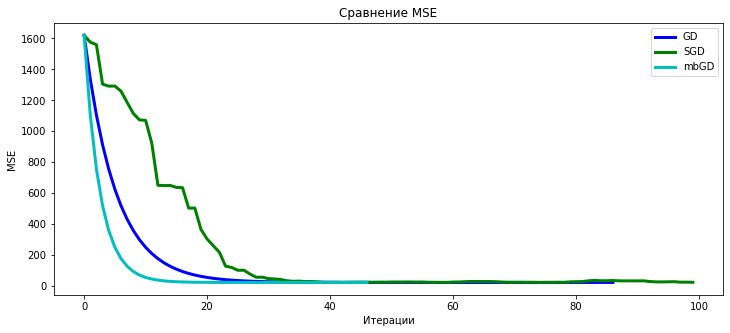

In [25]:
plt.figure(figsize=(12, 5))
plt.title('Сравнение MSE')
plt.ylabel('MSE')
plt.xlabel('Итерации')

n = 100
plt.plot(range(len(err_gd)), err_gd, c='b', linewidth=3, label='GD')
plt.plot(range(len(err_sgd))[:n], err_sgd[:n], linewidth=3, c='g', label='SGD')
plt.plot(range(len(err_mbgd)), err_mbgd, c='c', linewidth=3, label='mbGD')
plt.legend();

Вывод: скорость сходимости в большей степени определяется правильным подбором шага обучения. С точки зрения количества итераций очевидно, что SGD сходится за большее количество итераций. Но он может обучаться, используя меньше ресурсов оперативной памяти.
